Detected headers:
 - Person ID
 - Gender
 - Age
 - Occupation
 - Sleep Duration
 - Quality of Sleep
 - Physical Activity Level
 - Stress Level
 - BMI Category
 - Blood Pressure
 - Heart Rate
 - Daily Steps
 - Sleep Disorder

Auto-detected mapping (canonical_key -> detected header or None):
 person_id    -> Person ID
 gender       -> Gender
 age          -> Age
 occupation   -> Occupation
 sleep        -> Sleep Duration
 quality_sleep -> Quality of Sleep
 activity     -> Physical Activity Level
 stress       -> Stress Level
 bmi_cat      -> BMI Category
 blood_pressure -> Blood Pressure
 heart_rate   -> Heart Rate
 daily_steps  -> Daily Steps
 sleep_disorder -> Sleep Disorder
Saved results to results.csv

=== SAMPLE PREDICTIONS (FIRST 10 ROWS) ===
 risk_score risk_label  Heart Rate  Stress Level  Sleep Duration  Physical Activity Level
      83.58       High          77             6             6.1                       42
      70.83       High          75             8             6.

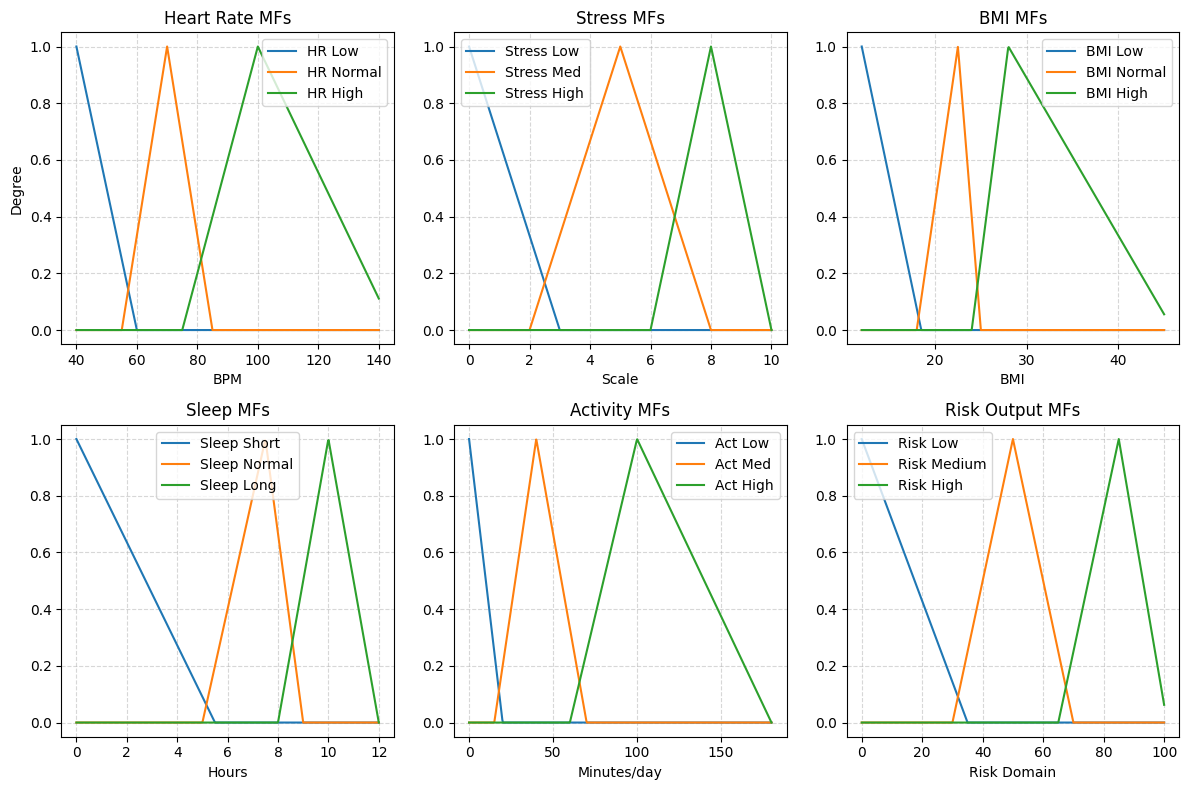

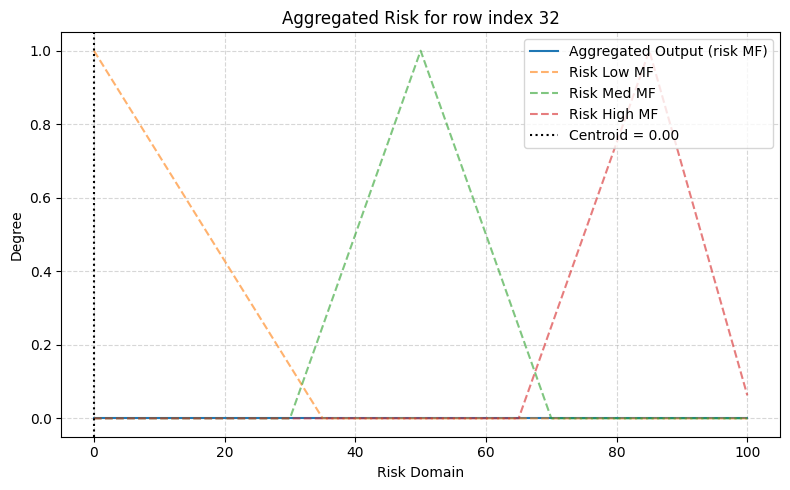

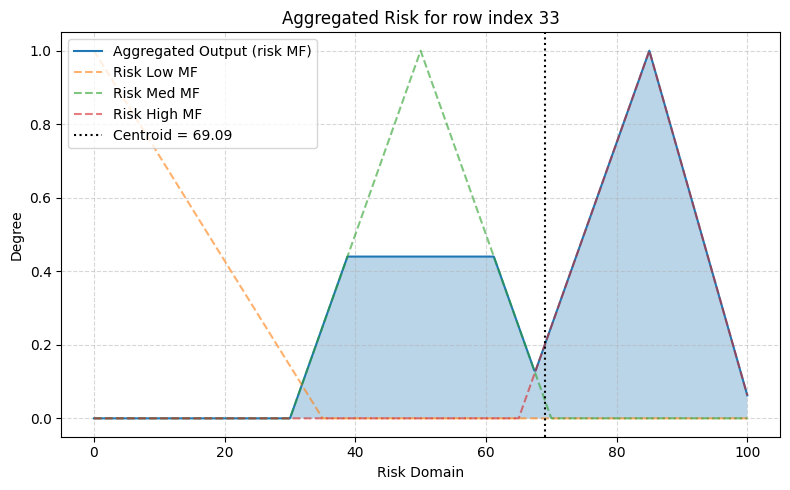

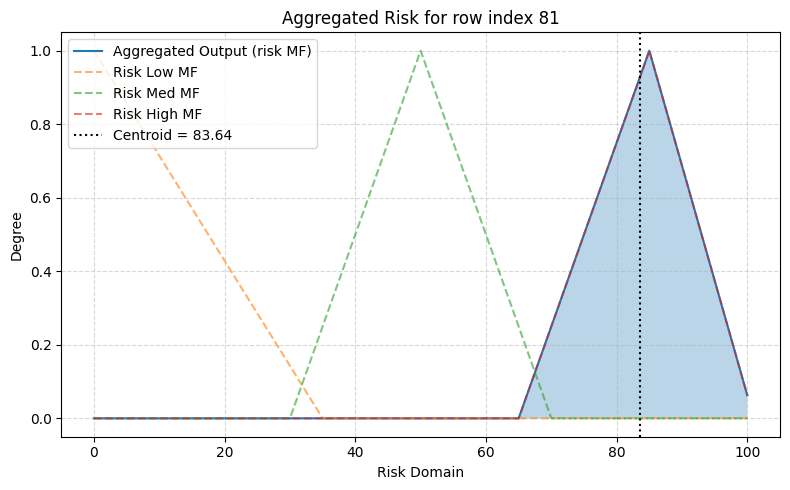

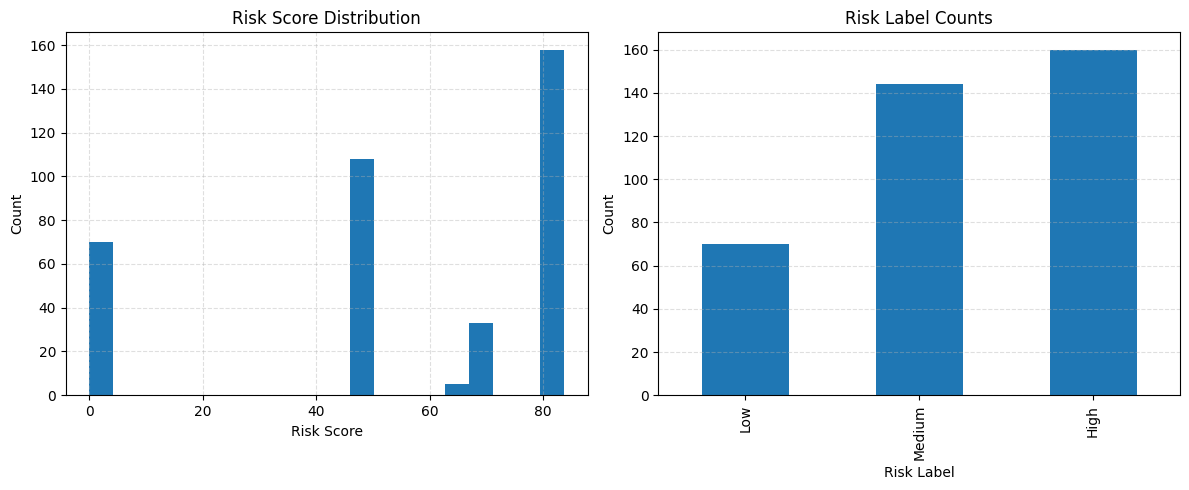

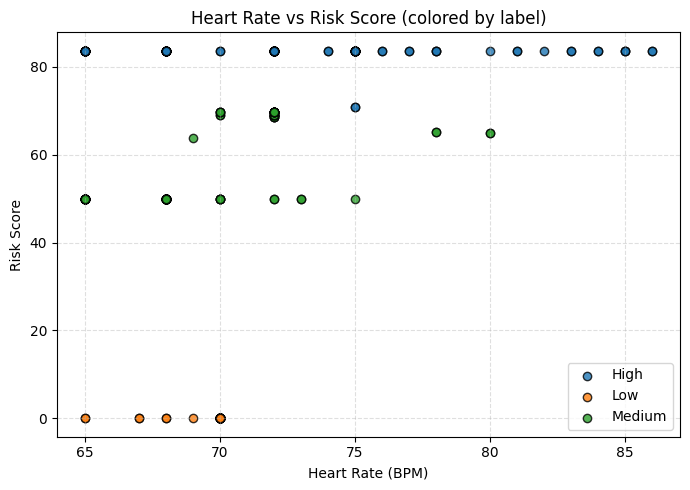

In [2]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- CONFIG ---
DATA_PATH = "Sleep_health_and_lifestyle_dataset.csv"
OUTPUT_PATH = "results.csv"
SAVE_DIR = "."  # where plots will be saved

# ---------- synonyms dictionary ----------
SYNONYMS = {
    "person_id": ["person id", "id", "person_id", "pid"],
    "gender": ["gender", "sex"],
    "age": ["age", "years"],
    "occupation": ["occupation", "job", "profession"],
    "sleep": ["sleep duration", "sleep_duration", "sleep_hours", "sleep (hours)", "sleep (hrs)", "sleep duration (hours)"],
    "quality_sleep": ["quality of sleep", "sleep quality", "sleep_quality"],
    "activity": ["physical activity level", "physical_activity", "activity minutes", "physical activity (minutes/day)", "physical activity level (minutes/day)"],
    "stress": ["stress level", "stress", "stress_level", "stress (scale: 1-10)"],
    "bmi_cat": ["bmi category", "bmi_category", "bmi category (eg underweight normal)"],
    "blood_pressure": ["blood pressure", "blood pressure (systolic/diastolic)", "bp", "blood_pressure"],
    "heart_rate": ["heart rate", "heart_rate", "pulse", "heart rate (bpm)"],
    "daily_steps": ["daily steps", "steps", "daily_steps"],
    "sleep_disorder": ["sleep disorder", "sleep_disorder"]
}

# ---------- helper to normalize header ----------
def norm(s):
    return re.sub(r'[^a-z0-9]', '', str(s).lower())

def build_header_map(headers):
    """
    Return dict mapping canonical keys -> actual header name found in CSV.
    If not found, value will be None.
    """
    norm_to_header = {norm(h): h for h in headers}
    header_map = {}
    for canon, variants in SYNONYMS.items():
        found = None
        for v in variants:
            vnorm = norm(v)
            if vnorm in norm_to_header:
                found = norm_to_header[vnorm]
                break
        # If still not found, try partial matching
        if not found:
            for h in headers:
                hn = norm(h)
                for v in variants:
                    if v.replace(" ", "") in hn or hn in v.replace(" ", ""):
                        found = h
                        break
                if found:
                    break
        header_map[canon] = found
    return header_map

# ---------- minimal fuzzy helpers ----------
def trimf(x, a, b, c):
    x = np.asarray(x, dtype=float)
    y = np.zeros_like(x, dtype=float)
    left = (x >= a) & (x <= b)
    right = (x >= b) & (x <= c)
    if b - a != 0:
        y[left] = (x[left] - a) / (b - a)
    else:
        y[left] = 1.0
    if c - b != 0:
        y[right] = (c - x[right]) / (c - b)
    else:
        y[right] = 1.0
    y[x == b] = 1.0
    return y

def centroid(x, mf):
    num = np.sum(x * mf)
    den = np.sum(mf)
    return (num / den) if den != 0 else 0.0

# Predefine domains & mfs (kept same as before)
HR_MIN, HR_MAX = 40, 140
x_hr = np.linspace(HR_MIN, HR_MAX, 501)
ST_MIN, ST_MAX = 0, 10
x_stress = np.linspace(ST_MIN, ST_MAX, 501)
BMI_MIN, BMI_MAX = 12, 45
x_bmi = np.linspace(BMI_MIN, BMI_MAX, 501)
S_MIN, S_MAX = 0, 12
x_sleep = np.linspace(S_MIN, S_MAX, 501)
ACT_MIN, ACT_MAX = 0, 180
x_act = np.linspace(ACT_MIN, ACT_MAX, 501)
OUT_MIN, OUT_MAX = 0, 100
x_out = np.linspace(OUT_MIN, OUT_MAX, 501)

hr_low = trimf(x_hr, HR_MIN-5, HR_MIN, 60)
hr_normal = trimf(x_hr, 55, 70, 85)
hr_high = trimf(x_hr, 75, 100, HR_MAX+5)

stress_low = trimf(x_stress, 0, 0, 3)
stress_med = trimf(x_stress, 2, 5, 8)
stress_high = trimf(x_stress, 6, 8, 10)

bmi_low = trimf(x_bmi, BMI_MIN-1, BMI_MIN, 18.5)
bmi_normal = trimf(x_bmi, 18.0, 22.5, 25.0)
bmi_high = trimf(x_bmi, 24.0, 28.0, BMI_MAX+1)

sleep_short = trimf(x_sleep, 0, 0, 5.5)
sleep_normal = trimf(x_sleep, 5, 7.5, 9)
sleep_long = trimf(x_sleep, 8, 10, S_MAX)

act_low = trimf(x_act, ACT_MIN-1, ACT_MIN, 20)
act_med = trimf(x_act, 15, 40, 70)
act_high = trimf(x_act, 60, 100, ACT_MAX)

risk_low = trimf(x_out, OUT_MIN-1, OUT_MIN, 35)
risk_med = trimf(x_out, 30, 50, 70)
risk_high = trimf(x_out, 65, 85, OUT_MAX+1)

# ---------- small util functions ----------
def parse_bp(bp_str):
    if pd.isna(bp_str):
        return None, None
    s = str(bp_str).strip()
    m = re.search(r'(\d{2,3})\s*[\/\-]\s*(\d{2,3})', s)
    if m:
        return int(m.group(1)), int(m.group(2))
    m2 = re.search(r'(\d{2,3})', s)
    if m2:
        return int(m2.group(1)), None
    return None, None

def map_bmi_category(cat):
    if pd.isna(cat):
        return 25.0
    c = str(cat).strip().lower()
    if "under" in c:
        return 17.0
    if "normal" in c or "healthy" in c:
        return 22.0
    if "over" in c:
        return 27.0
    if "obese" in c:
        return 32.0
    try:
        return float(re.findall(r"[\d\.]+", c)[0])
    except:
        return 25.0

# fuzzify & rules (compact)
def fuzzify_and_run(row):
    hr_v = float(row.get("heart_rate", 70))
    st_v = float(row.get("stress", 5))
    bmi_v = float(row.get("bmi_mapped", 25))
    sl_v = float(row.get("sleep", 7))
    act_v = float(row.get("activity", 30))

    deg = {}
    deg["hr_low"] = np.interp(hr_v, x_hr, hr_low)
    deg["hr_normal"] = np.interp(hr_v, x_hr, hr_normal)
    deg["hr_high"] = np.interp(hr_v, x_hr, hr_high)
    deg["stress_low"] = np.interp(st_v, x_stress, stress_low)
    deg["stress_med"] = np.interp(st_v, x_stress, stress_med)
    deg["stress_high"] = np.interp(st_v, x_stress, stress_high)
    deg["bmi_low"] = np.interp(bmi_v, x_bmi, bmi_low)
    deg["bmi_normal"] = np.interp(bmi_v, x_bmi, bmi_normal)
    deg["bmi_high"] = np.interp(bmi_v, x_bmi, bmi_high)
    deg["sleep_short"] = np.interp(sl_v, x_sleep, sleep_short)
    deg["sleep_normal"] = np.interp(sl_v, x_sleep, sleep_normal)
    deg["sleep_long"] = np.interp(sl_v, x_sleep, sleep_long)
    deg["act_low"] = np.interp(act_v, x_act, act_low)
    deg["act_med"] = np.interp(act_v, x_act, act_med)
    deg["act_high"] = np.interp(act_v, x_act, act_high)

    outputs = []
    # simple rules
    r1 = max(deg["hr_high"], deg["stress_high"], deg["bmi_high"])
    outputs.append(np.minimum(risk_high, r1))
    r2 = min(deg["hr_normal"], deg["stress_low"], deg["act_high"])
    outputs.append(np.minimum(risk_low, r2))
    r3 = min(deg["sleep_short"], deg["stress_high"])
    outputs.append(np.minimum(risk_high, r3))
    r4 = min(deg["bmi_normal"], deg["sleep_normal"], deg["act_med"])
    outputs.append(np.minimum(risk_med, r4))
    # aggregate
    agg = np.zeros_like(x_out)
    for o in outputs:
        agg = np.maximum(agg, o)
    score = centroid(x_out, agg)
    return score, float(np.max(np.minimum(agg, risk_low))), float(np.max(np.minimum(agg, risk_med))), float(np.max(np.minimum(agg, risk_high)))

# ---------- plotting helpers ----------
def plot_membership_functions(save_dir="."):
    """Plot membership functions for all input variables and risk output."""
    plt.figure(figsize=(12, 8))
    # Heart rate
    plt.subplot(2, 3, 1)
    plt.plot(x_hr, hr_low, label="HR Low")
    plt.plot(x_hr, hr_normal, label="HR Normal")
    plt.plot(x_hr, hr_high, label="HR High")
    plt.title("Heart Rate MFs")
    plt.xlabel("BPM")
    plt.ylabel("Degree")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Stress
    plt.subplot(2, 3, 2)
    plt.plot(x_stress, stress_low, label="Stress Low")
    plt.plot(x_stress, stress_med, label="Stress Med")
    plt.plot(x_stress, stress_high, label="Stress High")
    plt.title("Stress MFs")
    plt.xlabel("Scale")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # BMI
    plt.subplot(2, 3, 3)
    plt.plot(x_bmi, bmi_low, label="BMI Low")
    plt.plot(x_bmi, bmi_normal, label="BMI Normal")
    plt.plot(x_bmi, bmi_high, label="BMI High")
    plt.title("BMI MFs")
    plt.xlabel("BMI")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Sleep
    plt.subplot(2, 3, 4)
    plt.plot(x_sleep, sleep_short, label="Sleep Short")
    plt.plot(x_sleep, sleep_normal, label="Sleep Normal")
    plt.plot(x_sleep, sleep_long, label="Sleep Long")
    plt.title("Sleep MFs")
    plt.xlabel("Hours")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Activity
    plt.subplot(2, 3, 5)
    plt.plot(x_act, act_low, label="Act Low")
    plt.plot(x_act, act_med, label="Act Med")
    plt.plot(x_act, act_high, label="Act High")
    plt.title("Activity MFs")
    plt.xlabel("Minutes/day")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    # Risk output MFs
    plt.subplot(2, 3, 6)
    plt.plot(x_out, risk_low, label="Risk Low")
    plt.plot(x_out, risk_med, label="Risk Medium")
    plt.plot(x_out, risk_high, label="Risk High")
    plt.title("Risk Output MFs")
    plt.xlabel("Risk Domain")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)

    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, "membership_functions.png"), dpi=150)
    plt.show()


def plot_aggregated_risk_for_index(work_df, idx=0, save_dir="."):
    """
    Recompute fuzzification & aggregation for a specific index and plot the aggregated output surface.
    idx: row index in the working DataFrame (work)
    """
    if idx < 0 or idx >= len(work_df):
        print("Index out of range for aggregated plot.")
        return
    row = work_df.iloc[idx]

    # replicate fuzzification (same as fuzzify_and_run but keep 'agg' array)
    hr_v = float(row.get("heart_rate", 70))
    st_v = float(row.get("stress", 5))
    bmi_v = float(row.get("bmi_mapped", 25))
    sl_v = float(row.get("sleep", 7))
    act_v = float(row.get("activity", 30))

    deg = {}
    deg["hr_low"] = np.interp(hr_v, x_hr, hr_low)
    deg["hr_normal"] = np.interp(hr_v, x_hr, hr_normal)
    deg["hr_high"] = np.interp(hr_v, x_hr, hr_high)
    deg["stress_low"] = np.interp(st_v, x_stress, stress_low)
    deg["stress_med"] = np.interp(st_v, x_stress, stress_med)
    deg["stress_high"] = np.interp(st_v, x_stress, stress_high)
    deg["bmi_low"] = np.interp(bmi_v, x_bmi, bmi_low)
    deg["bmi_normal"] = np.interp(bmi_v, x_bmi, bmi_normal)
    deg["bmi_high"] = np.interp(bmi_v, x_bmi, bmi_high)
    deg["sleep_short"] = np.interp(sl_v, x_sleep, sleep_short)
    deg["sleep_normal"] = np.interp(sl_v, x_sleep, sleep_normal)
    deg["sleep_long"] = np.interp(sl_v, x_sleep, sleep_long)
    deg["act_low"] = np.interp(act_v, x_act, act_low)
    deg["act_med"] = np.interp(act_v, x_act, act_med)
    deg["act_high"] = np.interp(act_v, x_act, act_high)

    outputs = []
    r1 = max(deg["hr_high"], deg["stress_high"], deg["bmi_high"])
    outputs.append(np.minimum(risk_high, r1))
    r2 = min(deg["hr_normal"], deg["stress_low"], deg["act_high"])
    outputs.append(np.minimum(risk_low, r2))
    r3 = min(deg["sleep_short"], deg["stress_high"])
    outputs.append(np.minimum(risk_high, r3))
    r4 = min(deg["bmi_normal"], deg["sleep_normal"], deg["act_med"])
    outputs.append(np.minimum(risk_med, r4))

    agg = np.zeros_like(x_out)
    for o in outputs:
        agg = np.maximum(agg, o)

    c = centroid(x_out, agg)
    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot(x_out, agg, label="Aggregated Output (risk MF)")
    plt.fill_between(x_out, 0, agg, alpha=0.3)
    plt.plot(x_out, risk_low, linestyle="--", alpha=0.6, label="Risk Low MF")
    plt.plot(x_out, risk_med, linestyle="--", alpha=0.6, label="Risk Med MF")
    plt.plot(x_out, risk_high, linestyle="--", alpha=0.6, label="Risk High MF")
    plt.axvline(c, color="k", linestyle=":", label=f"Centroid = {c:.2f}")
    plt.title(f"Aggregated Risk for row index {idx}")
    plt.xlabel("Risk Domain")
    plt.ylabel("Degree")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    fname = os.path.join(save_dir, f"aggregated_risk_row_{idx}.png")
    plt.savefig(fname, dpi=150)
    plt.show()
    return c


def plot_risk_distribution_and_scatter(result_df, work_df, save_dir="."):
    """Plot histogram of risk scores and scatter of heart_rate vs risk_score colored by label."""
    # histogram
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(result_df["risk_score"].dropna(), bins=20)
    plt.title("Risk Score Distribution")
    plt.xlabel("Risk Score")
    plt.ylabel("Count")
    plt.grid(True, linestyle="--", alpha=0.4)

    # counts by label
    plt.subplot(1, 2, 2)
    counts = result_df["risk_label"].value_counts().reindex(["Low", "Medium", "High"]).fillna(0)
    counts.plot(kind="bar")
    plt.title("Risk Label Counts")
    plt.xlabel("Risk Label")
    plt.ylabel("Count")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.tight_layout()
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, "risk_distribution.png"), dpi=150)
    plt.show()

    # scatter: heart_rate vs risk_score colored by risk_label
    labels = result_df["risk_label"].astype(str)
    uniq = labels.unique()
    plt.figure(figsize=(7, 5))
    for i, lab in enumerate(uniq):
        mask = (labels == lab)
        plt.scatter(work_df.loc[mask, "heart_rate"], result_df.loc[mask, "risk_score"],
                    label=lab, edgecolors='k', alpha=0.8)
    plt.xlabel("Heart Rate (BPM)")
    plt.ylabel("Risk Score")
    plt.title("Heart Rate vs Risk Score (colored by label)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "hr_vs_risk_scatter.png"), dpi=150)
    plt.show()

def plot_all(result, work, save_dir="."):
    plot_membership_functions(save_dir=save_dir)
    # plot aggregated risk for a few interesting rows: highest, median, lowest
    try:
        sorted_idx = np.argsort(result["risk_score"].values)
        if len(sorted_idx) > 0:
            # lowest
            plot_aggregated_risk_for_index(work, int(sorted_idx[0]), save_dir=save_dir)
        if len(sorted_idx) > 1:
            # median
            plot_aggregated_risk_for_index(work, int(sorted_idx[len(sorted_idx)//2]), save_dir=save_dir)
        if len(sorted_idx) > 2:
            # highest
            plot_aggregated_risk_for_index(work, int(sorted_idx[-1]), save_dir=save_dir)
    except Exception as e:
        print("Could not plot aggregated risk for sample indices:", e)
    plot_risk_distribution_and_scatter(result, work, save_dir=save_dir)

# ---------- main ----------
def safe_column_find(result_df, patterns, default=None):
    for p in patterns:
        try:
            matches = result_df.columns[result_df.columns.str.contains(p, case=False)]
            if len(matches) > 0:
                return matches[0]
        except Exception:
            continue
    return default

def main():
    if not os.path.exists(DATA_PATH):
        print("File not found:", DATA_PATH)
        return
    df = pd.read_csv(DATA_PATH)
    headers = list(df.columns)
    print("Detected headers:")
    for h in headers:
        print(" -", h)
    header_map = build_header_map(headers)
    print("\nAuto-detected mapping (canonical_key -> detected header or None):")
    for k, v in header_map.items():
        print(f" {k:12s} -> {v}")

    # required canonical columns for our processing:
    required_keys = ["heart_rate", "stress", "bmi_cat", "sleep", "activity", "blood_pressure"]
    missing = [k for k in required_keys if header_map.get(k) is None]
    if missing:
        print("\nWARNING: some required fields were NOT detected. Missing keys:", missing)
        print("If your dataset uses other column names, either rename the CSV headers or adjust SYNONYMS.")

    # Build a working DataFrame with canonical column names
    work = pd.DataFrame()
    # heart rate
    if header_map.get("heart_rate"):
        work["heart_rate"] = pd.to_numeric(df[header_map["heart_rate"]], errors="coerce").fillna(70)
    else:
        work["heart_rate"] = 70
    # stress
    if header_map.get("stress"):
        work["stress"] = pd.to_numeric(df[header_map["stress"]], errors="coerce").fillna(5)
    else:
        work["stress"] = 5
    # bmi
    if header_map.get("bmi_cat"):
        work["bmi_mapped"] = df[header_map["bmi_cat"]].map(map_bmi_category)
    else:
        # try to find numeric BMI column by heuristics
        possible = [c for c in headers if "bmi" in norm(c)]
        if possible:
            work["bmi_mapped"] = pd.to_numeric(df[possible[0]], errors="coerce").fillna(25)
            print("Using numeric BMI column:", possible[0])
        else:
            work["bmi_mapped"] = 25.0
    # sleep
    if header_map.get("sleep"):
        work["sleep"] = pd.to_numeric(df[header_map["sleep"]], errors="coerce").fillna(7)
    else:
        poss = [c for c in headers if "sleep" in norm(c)]
        if poss:
            work["sleep"] = pd.to_numeric(df[poss[0]], errors="coerce").fillna(7)
            print("Using sleep column:", poss[0])
        else:
            work["sleep"] = 7.0
    # activity
    if header_map.get("activity"):
        work["activity"] = pd.to_numeric(df[header_map["activity"]], errors="coerce").fillna(30)
    else:
        poss = [c for c in headers if "activity" in norm(c) or "step" in norm(c)]
        if poss:
            work["activity"] = pd.to_numeric(df[poss[0]], errors="coerce").fillna(30)
            print("Using activity column:", poss[0])
        else:
            work["activity"] = 30.0
    # blood pressure parse for optional use
    if header_map.get("blood_pressure"):
        s_bp = df[header_map["blood_pressure"]].map(lambda x: parse_bp(x)[0] if not pd.isna(x) else np.nan).fillna(120)
        work["systolic_bp"] = s_bp
    else:
        possibile = [c for c in headers if "blood" in norm(c) or "bp" in norm(c)]
        if possibile:
            s_bp = df[possibile[0]].map(lambda x: parse_bp(x)[0] if not pd.isna(x) else np.nan).fillna(120)
            work["systolic_bp"] = s_bp
            print("Using BP column:", possibile[0])
        else:
            work["systolic_bp"] = 120.0

    # clip ranges
    work["heart_rate"] = work["heart_rate"].clip(HR_MIN, HR_MAX)
    work["stress"] = work["stress"].clip(ST_MIN, ST_MAX)
    work["bmi_mapped"] = work["bmi_mapped"].clip(BMI_MIN, BMI_MAX)
    work["sleep"] = work["sleep"].clip(S_MIN, S_MAX)
    work["activity"] = work["activity"].clip(ACT_MIN, ACT_MAX)
    work["systolic_bp"] = work["systolic_bp"].clip(80, 200)

    # run fuzzy scoring
    scores = []
    lows, meds, highs = [], [], []
    for _, row in work.iterrows():
        sc, dl, dm, dh = fuzzify_and_run(row)
        scores.append(round(float(sc), 2))
        lows.append(round(float(dl), 3))
        meds.append(round(float(dm), 3))
        highs.append(round(float(dh), 3))

    result = df.copy()
    result["risk_score"] = scores
    result["deg_low"] = lows
    result["deg_med"] = meds
    result["deg_high"] = highs

    # label
    def label_from_score(s):
        if s < 40: return "Low"
        if s < 70: return "Medium"
        return "High"
    result["risk_label"] = result["risk_score"].apply(label_from_score)
    result.to_csv(OUTPUT_PATH, index=False)
    print("Saved results to", OUTPUT_PATH)

    # safe selection of representative columns for printing
    heart_col = safe_column_find(result, ["heart", "hr", "pulse"], default=None)
    stress_col = safe_column_find(result, ["stress"], default=None)
    sleep_col = safe_column_find(result, ["sleep"], default=None)
    activity_col = safe_column_find(result, ["activity", "step", "steps"], default=None)

    print("\n=== SAMPLE PREDICTIONS (FIRST 10 ROWS) ===")
    cols_to_show = ["risk_score", "risk_label"]
    for c in [heart_col, stress_col, sleep_col, activity_col]:
        if c is not None:
            cols_to_show.append(c)
    # remove duplicates and ensure existence
    cols_to_show = [c for i, c in enumerate(cols_to_show) if c and c in result.columns and c not in cols_to_show[:i]]
    print(result[cols_to_show].head(10).to_string(index=False))

    print("Risk label counts:", result["risk_label"].value_counts().to_dict())

    # plotting
    try:
        plot_all(result, work, save_dir=SAVE_DIR)
    except Exception as e:
        print("Plotting failed:", e)

if __name__ == "__main__":
    main()
